In [1]:
# Here i tested a built in way of cross-validating in order to evaulate the estimators preformance
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
import matplotlib as plt
import numpy as np
import zipfile
import os

# Unzip KO terms
zip_file_path_KO = 'terms_KO.zip' 
csv_file_name_KO = 'terms_KO.csv' 

# Unzip reduced dataset
zip_file_path = 'reducedDataset.zip' 
csv_file_name = 'reducedDataset.csv' 

In [2]:
# Reads and processes GO terms
with zipfile.ZipFile(zip_file_path_KO, 'r') as z:
    with z.open(csv_file_name_KO) as file:
        KOs = pd.read_csv(file, index_col=0)

KOs['value'] = 1
X_terms = KOs.pivot_table(index='key', columns='KO', values='value', fill_value=0)

In [3]:
# Processes data for traits
with zipfile.ZipFile(zip_file_path, 'r') as zip:
    with zip.open(csv_file_name) as file:
        traits = pd.read_csv(file, sep=';')

oxygen_mapping = {
    'Aerobic': 'Aerobic',
    'aerotolerant': 'Aerobic',
    'microaerophilic': 'Aerobic',
    'obligate aerobic': 'Aerobic',
    'anaerobic': 'Anaerobic',
    'obligate anaerobic': 'Anaerobic',
    'conflict': 'Facultative',
    'facultative': 'Facultative'
}
traits['oxygen'] = traits['oxygen'].map(oxygen_mapping)

# The missing values for the oxygen column are removed and then the keys are grouped together
y = traits.dropna(subset=['oxygen']).groupby('key').agg({'oxygen': lambda x: x.value_counts().index[0]})

In [4]:
# Finds all the common keys between X and Y due to descrepancies adter the removal of empty oxygen values
common_keys = X_terms.index.intersection(y.index)

In [5]:
# Align X and Y based on common keys
X = X_terms.loc[common_keys]
Y = y.loc[common_keys].values.ravel()
# Ensures X and Y are aligned
assert X.shape[0] == len(Y), "X and Y are not aligned"

In [6]:
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)
class_names =traits

Shape of X: (1382, 10188)
Shape of Y: (1382,)


In [7]:
# Normalize Data
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [8]:
# The feature Selection
select_k = SelectKBest(chi2, k=20)  # Adjust 'k' as needed
X_new = select_k.fit_transform(X_norm, Y)

ValueError: Input X must be non-negative.

In [7]:
# Testing using cross-validated metrics
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=0.4, random_state=0)

# Checking that all datasets have the correct shape
X_train.shape, Y_train.shape
X_test.shape, Y_test.shape

# The classification algorithm
clf = svm.SVC(kernel="linear", C=1)


# Preforms on the training data
scores = cross_val_score(clf, X_train, Y_train, cv=5)
# Checking the scores for the different interations of the cross-validation
scores

In [8]:
# Evaluating the fit of the model
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

# Here you can use accuracy_score, confusion_matrix, etc. for evaluating Y_test vs Y_pred

# Cross validation scores:
print("Cross-Validation Scores:", scores)

array([0.35529929, 0.34969057])

Confusion matrix, without normalization
[[685   0  10   0  41   5   9   0]
 [  0   1   1   0   0   0   0   0]
 [ 11   0 176   0  11   4   0   6]
 [  1   0   0   0   1   0   0   0]
 [ 81   0  15   0  58  14   0   0]
 [ 18   0   3   0  21  69   0   0]
 [ 40   0   0   0   1   0   3   0]
 [  0   0  17   0   0   1   0   0]]
Normalized confusion matrix
[[0.91 0.   0.01 0.   0.05 0.01 0.01 0.  ]
 [0.   0.5  0.5  0.   0.   0.   0.   0.  ]
 [0.05 0.   0.85 0.   0.05 0.02 0.   0.03]
 [0.5  0.   0.   0.   0.5  0.   0.   0.  ]
 [0.48 0.   0.09 0.   0.35 0.08 0.   0.  ]
 [0.16 0.   0.03 0.   0.19 0.62 0.   0.  ]
 [0.91 0.   0.   0.   0.02 0.   0.07 0.  ]
 [0.   0.   0.94 0.   0.   0.06 0.   0.  ]]


AttributeError: module 'matplotlib' has no attribute 'show'

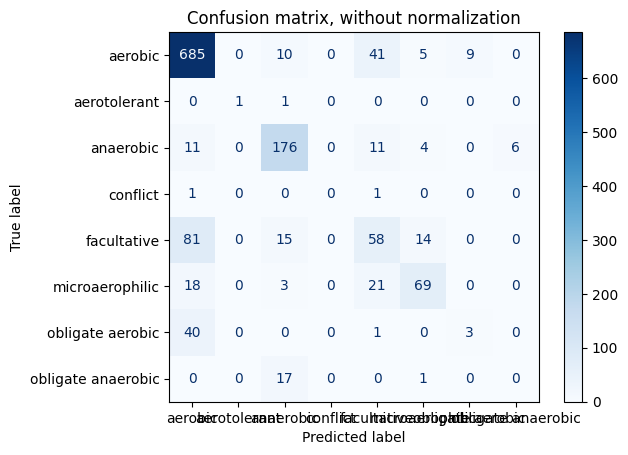

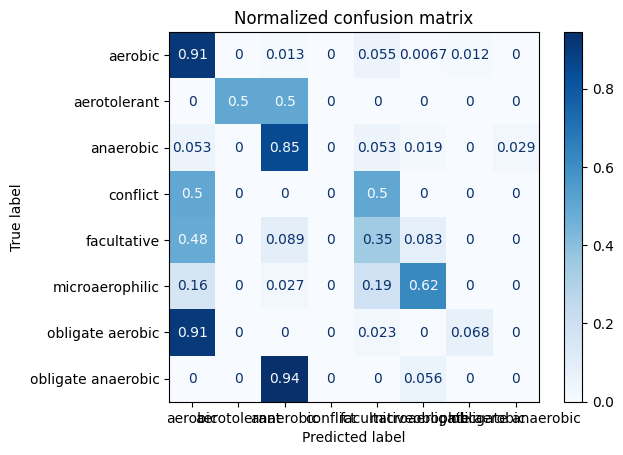

In [10]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        clf,
        X_test,
        Y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()